# Generalising the updraft-downdraft coupling results

In [104]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
import pandas as pd
from scipy.interpolate import interp1d
import sys
import shelve

import metpy.calc as mpcalc
from metpy.units import units, concatenate
from metpy.plots import SkewT

from dparcel.thermo import (saturation_specific_humidity,
                            equivalent_potential_temperature)
sys.path.append('../convection_scheme')
from coupler import CoupledThermalGenerator

## Helper functions

In [17]:
def downdraft_init_levels(generator, thickness):
    """Get initiation and precipitation top levels for downdrafts."""
    i_init_down_min = np.min(np.argwhere(generator.height <= 4000*units.meter))
    i_init_down_max = np.max(np.argwhere(generator.height >= 500*units.meter))
    i_init_down = range(i_init_down_min, i_init_down_max+1, 2)
    z_init_down = generator.height[i_init_down_min:i_init_down_max+1:2]
    i_precip_top = np.argmin(np.abs(
        np.atleast_2d(generator.height)
        - np.atleast_2d(z_init_down + thickness).T
    ), axis=1)
    return i_init_down, z_init_down, i_precip_top

In [191]:
def run_updraft(generator, t_pert, l_crit, epsilon_up, drag):
    """Run the updraft calculation."""
    i_init_up = generator.pressure.size - 1
    q_pert = (
        saturation_specific_humidity(
            generator.pressure[i_init_up], generator.temperature[i_init_up])
         - generator.specific_humidity[i_init_up]
    )/1.5
    updraft = generator.updraft(
        i_init_up, t_pert, q_pert, l_initial, w_initial,
        epsilon_up, dnu_db, drag, l_crit, basic=True)
    return updraft

In [39]:
def get_total_precip(updraft, i_init_down, i_precip_top):
    """Calculate total precipitation."""
    total_precip = np.zeros(len(i_init_down))*units('')
    for i in range(len(i_init_down)):
        total_precip[i] = np.nansum((
            updraft.precipitation*updraft.m_remaining
        )[i_precip_top[i] : i_init_down[i] + 1])
    return total_precip

In [40]:
def run_downdrafts(generator, i_init_down, total_precip, drag):
    """Run the downdraft calculations."""
    downdrafts = np.zeros((len(i_init_down), epsilon_down.size),
                          dtype='object')
    n_calc = epsilon_down.size*len(i_init_down)
    n_done = 0
    for i in range(len(i_init_down)):
        for j in range(epsilon_down.size):
            n_done += 1
            sys.stdout.write(f'\r        Calculation {n_done} of {n_calc}    ')
            downdrafts[i,j] = generator.precipitation_downdraft(
                i_init_down[i], total_precip[i], w_initial,
                epsilon_down[j], dnu_db, drag, basic=True)
    sys.stdout.write('\n')
    return downdrafts

In [209]:
def get_downdraft_data(generator, downdrafts):
    """Find max downdraft velocity and min height."""
    max_velocity = np.zeros(downdrafts.shape)*units('m/s')
    max_velocity_height = np.zeros(downdrafts.shape)*units.meter
    min_height = np.zeros(downdrafts.shape)*units.meter

    for i in range(downdrafts.shape[0]):
        for j in range(downdrafts.shape[1]):
            max_velocity_i = np.nanargmin(downdrafts[i,j].velocity)
            max_velocity[i,j] = downdrafts[i,j].velocity[max_velocity_i]
            max_velocity_height[i,j] = generator.height[max_velocity_i]
            min_height_i = np.max(
                np.argwhere(~np.isnan(downdrafts[i,j].velocity)))
            min_height[i,j] = generator.height[min_height_i]
            
    return max_velocity, max_velocity_height, min_height

In [210]:
def multiple_downdraft_runs(generator, name, thickness, t_pert, l_crit, drag):
    """Do a downdraft run for each updraft entrainment rate."""
    print('Starting run ' + name + ' ...')
    
    (i_init_down,
     z_init_down,
     i_precip_top) = downdraft_init_levels(generator, thickness)
    theta_e = equivalent_potential_temperature(
        generator.pressure, generator.temperature, generator.specific_humidity)
    z_min_theta_e = generator.height[np.argmin(theta_e)]
    
    w_max_all = []
    z_w_max_all = []
    z_min_all = []
    z_max_evap_all = []
    
    for eps in epsilon_up:
        print('    epsilon_up = {:.2f} /km ...'.format(eps.m))
        updraft = run_updraft(generator, t_pert, l_crit, eps, drag)
        total_precip = get_total_precip(updraft, i_init_down, i_precip_top)
        downdrafts = run_downdrafts(generator, i_init_down, total_precip, drag)
        w_max, z_w_max, z_min = get_downdraft_data(generator, downdrafts)
        z_max_evap = z_init_down[np.argmax(total_precip, axis=0)]
        
        w_max_all.append(w_max)
        z_w_max_all.append(z_w_max)
        z_min_all.append(z_min)
        z_max_evap_all.append(z_max_evap)
        
    with shelve.open('generalising_coupling_data/' + name) as db:
        db['z_init_down'] = z_init_down
        db['z_min_theta_e'] = z_min_theta_e
        db['z_max_evap'] = z_max_evap_all
        db['w_max'] = w_max_all
        db['z_w_max'] = z_w_max_all
        db['z_min'] = z_min_all

## Soundings

In [91]:
def prepare_sounding(file, n_drop=0):
    """Create a generator object from a sounding data file."""
    sounding = pd.read_fwf(file, usecols=[0, 1, 2, 3], header=0)
    sounding = sounding.to_numpy()
    
    rows = slice(-1, n_drop - 1 if n_drop > 0 else None, -1)
    pressure_raw = sounding[rows,0]
    height_raw = sounding[rows,1]
    height_raw -= np.min(height_raw)
    temperature_raw = sounding[rows,2]
    dewpoint_raw = sounding[rows,3]

    pressure = np.arange(pressure_raw[-1], pressure_raw[0], -5)*units.mbar
    pressure = np.flip(pressure)
    height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
    temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
    dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius
    specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)
    return CoupledThermalGenerator(
        pressure, height, temperature, specific_humidity)

In [129]:
file = ('test_soundings/48698 WSSS Singapore Observations '
        'at 00Z 01 Dec 2021.txt')
singapore = prepare_sounding(file, 3)
singapore.name = '48698 WSSS Singapore Observations\nat 00Z 01 Dec 2021'

In [155]:
file = ('test_soundings/94776 YSWM Williamtown Amo Raaf Observations '
        'at 00Z 21 Dec 2021.txt')
williamtown = prepare_sounding(file, 1)
williamtown.name = ('94776 YSWM Williamtown Amo Raaf Observations'
                    '\nat 00Z 21 Dec 2021')

In [131]:
file = ('test_soundings/91285 PHTO Hilo Observations at 00Z 07 Dec 2021.txt')
hilo = prepare_sounding(file, 0)
hilo.name = '91285 PHTO Hilo Observations\nat 00Z 07 Dec 2021'

In [128]:
file = ('test_soundings/94120 YPDN Darwin Airport Observations '
        'at 12Z 30 Jan 2021.txt')
darwin = prepare_sounding(file, 0)
darwin.name = '94120 YPDN Darwin Airport Observations\nat 12Z 30 Jan 2021'

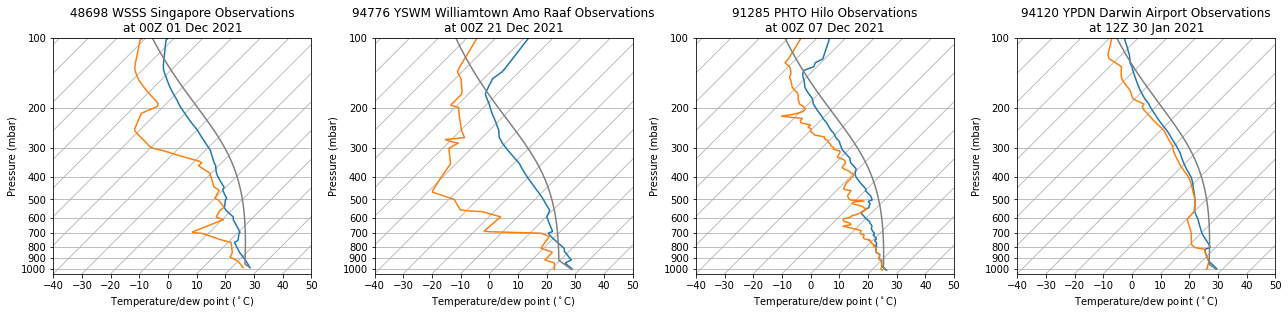

In [144]:
fig = plt.figure(figsize=(18,5))
for i, sounding in enumerate([singapore, williamtown, hilo, darwin]):
    skew = SkewT(fig, rotation=45, subplot=(1, 4, i+1))
    skew.plot(sounding.pressure, sounding.temperature)
    dewpoint = mpcalc.dewpoint_from_specific_humidity(
        sounding.pressure, sounding.temperature, sounding.specific_humidity)
    skew.plot(sounding.pressure, dewpoint)
    profile = mpcalc.parcel_profile(
        sounding.pressure[::-1], sounding.temperature[-1], dewpoint[-1])
    skew.plot(sounding.pressure[::-1], profile, color='0.5')
    skew.ax.set(xlabel='Temperature/dew point ($^\circ$C)',
                ylabel='Pressure (mbar)',
                title=sounding.name)
fig.tight_layout()

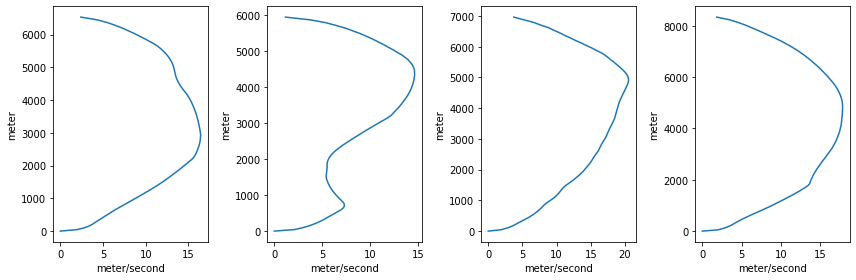

In [282]:
fig, axes = plt.subplots(1, 4, figsize=(12,4))
for i, generator in enumerate([singapore, williamtown, hilo, darwin]):
    # updraft parameters
    i_init_up = generator.pressure.size - 1
    t_pert = 1.0*units.delta_degC
    q_pert = (
        saturation_specific_humidity(
            generator.pressure[i_init_up], generator.temperature[i_init_up])
         - generator.specific_humidity[i_init_up]
    )/1.5
    l_initial = 0*units.dimensionless
    l_crit = 2.0e-3*units.dimensionless

    # shared parameters
    w_initial = 0*units.meter/units.second
    rate = 0.5/units.km
    dnu_db = 0*units.second**2/units.meter**2
    drag = 0/units.km

    updraft = generator.updraft(
        i_init_up, t_pert, q_pert, l_initial, w_initial,
        rate, dnu_db, drag, l_crit, basic=True)

    axes[i].plot(updraft.velocity, generator.height)
fig.tight_layout()

## Experiment

In [204]:
# fixed parameters
thickness = 2*units.km
t_pert = 1*units.delta_degC
l_crit = 2e-3*units.dimensionless
drag = 0/units.km
l_initial = 0*units.dimensionless
w_initial = 0*units.meter/units.second
epsilon_down = np.arange(0.05, 0.601, 0.02)*(1/units.km)
epsilon_up = [0.1, 0.3, 0.5]*(1/units.km)
dnu_db = 0*units.second**2/units.meter**2

In [211]:
%%time
multiple_downdraft_runs(
    singapore, 'singapore', thickness, t_pert, l_crit, drag)

Starting run singapore ...
    epsilon_up = 0.10 /km ...
        Calculation 896 of 896    
    epsilon_up = 0.30 /km ...
        Calculation 896 of 896    
    epsilon_up = 0.50 /km ...
        Calculation 896 of 896    
CPU times: user 5min 32s, sys: 2.03 s, total: 5min 34s
Wall time: 5min 34s


In [212]:
%%time
multiple_downdraft_runs(
    williamtown, 'williamtown', thickness, t_pert, l_crit, drag)

Starting run williamtown ...
    epsilon_up = 0.10 /km ...
        Calculation 896 of 896    
    epsilon_up = 0.30 /km ...
        Calculation 896 of 896    
    epsilon_up = 0.50 /km ...
        Calculation 896 of 896    
CPU times: user 6min 1s, sys: 2.23 s, total: 6min 3s
Wall time: 6min 4s


In [213]:
%%time
multiple_downdraft_runs(
    hilo, 'hilo', thickness, t_pert, l_crit, drag)

Starting run hilo ...
    epsilon_up = 0.10 /km ...
        Calculation 924 of 924    
    epsilon_up = 0.30 /km ...
        Calculation 924 of 924    
    epsilon_up = 0.50 /km ...
        Calculation 924 of 924    
CPU times: user 5min 59s, sys: 2.94 s, total: 6min 2s
Wall time: 6min 4s


In [214]:
%%time
multiple_downdraft_runs(
    darwin, 'darwin', thickness, t_pert, l_crit, drag)

Starting run darwin ...
    epsilon_up = 0.10 /km ...
        Calculation 896 of 896    
    epsilon_up = 0.30 /km ...
        Calculation 896 of 896    
    epsilon_up = 0.50 /km ...
        Calculation 896 of 896    
CPU times: user 5min 39s, sys: 2.26 s, total: 5min 42s
Wall time: 5min 42s


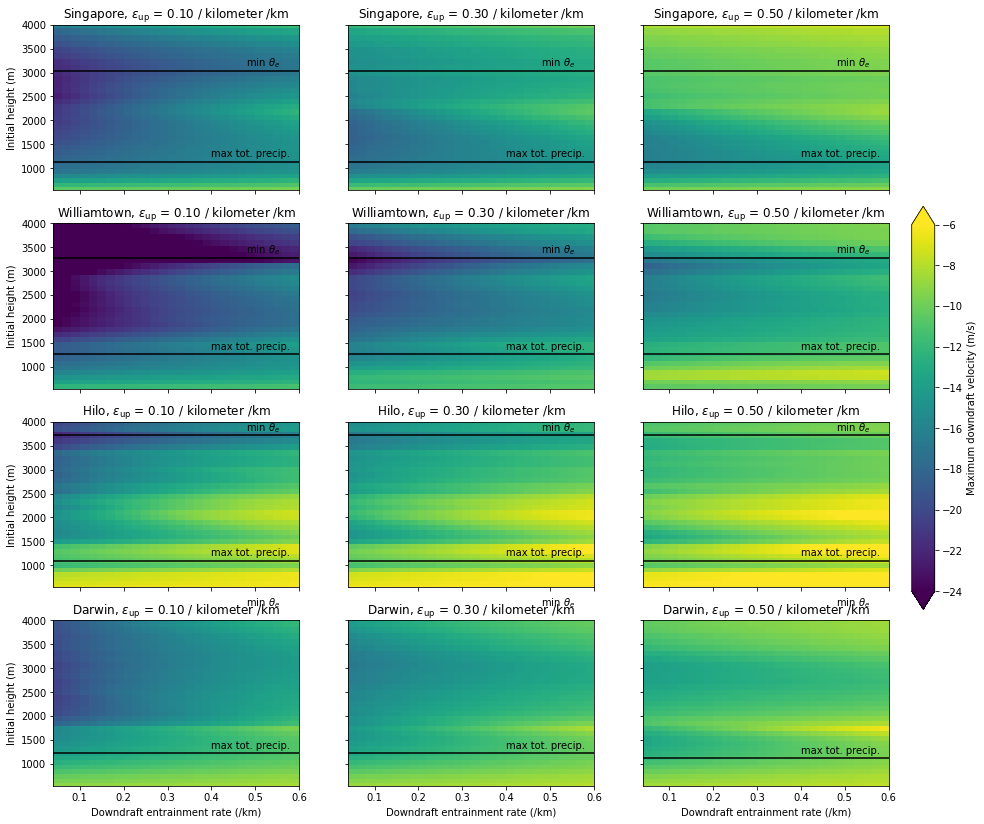

In [250]:
fig, axes = plt.subplots(4, 3, figsize=(16,14))

for i, name in enumerate(['singapore', 'williamtown', 'hilo', 'darwin']):
    db = shelve.open('generalising_coupling_data/' + name)
    for j, eps in enumerate(epsilon_up):
        mesh = axes[i,j].pcolormesh(
            epsilon_down, db['z_init_down'], db['w_max'][j], shading='nearest')
        mesh.set_clim(-24, -6)
        
        axes[i,j].axhline(db['z_max_evap'][j].m, color='k')
        axes[i,j].text(0.4, db['z_max_evap'][j].m + 100, 'max tot. precip.')
        axes[i,j].axhline(db['z_min_theta_e'].m, color='k',
                          label='min $\\theta_e$')
        axes[i,j].text(0.48, db['z_min_theta_e'].m + 100,
                       'min $\\theta_e$', color='k')
        
        title = (name.capitalize()
                 + r', $\epsilon_\mathrm{{up}}$ = {:.2f} /km'.format(eps))
        axes[i,j].set(xlabel='Downdraft entrainment rate (/km)',
                      ylabel='Initial height (m)',
                      title=title)
        axes[i,j].set_ylim(540, 4000)
    db.close()

for ax in axes[:,1:].ravel():
    ax.set_ylabel('')
    ax.set_yticklabels([])
for ax in axes[:-1,:].ravel():
    ax.set_xlabel('')
    ax.set_xticklabels([])
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.3, 0.02, 0.4])
cbar = fig.colorbar(mesh, cax=cbar_ax, extend='both')
cbar.set_label('Maximum downdraft velocity (m/s)')

# fig.tight_layout()

## Singapore, 5 K warmer

In [279]:
file = ('test_soundings/48698 WSSS Singapore Observations '
        'at 00Z 01 Dec 2021.txt')
n_drop = 3
sounding = pd.read_fwf(file, usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()

rows = slice(-1, n_drop - 1 if n_drop > 0 else None, -1)
pressure_raw = sounding[rows,0]
height_raw = sounding[rows,1]
height_raw -= np.min(height_raw)
temperature_raw = sounding[rows,2]
dewpoint_raw = sounding[rows,3]

pressure = np.arange(pressure_raw[-1], pressure_raw[0], -5)*units.mbar
pressure = np.flip(pressure)
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius

rh_original = mpcalc.relative_humidity_from_dewpoint(temperature, dewpoint)
temperature += 5*units.delta_degC
dewpoint = mpcalc.dewpoint_from_relative_humidity(temperature, rh_original)
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)

singapore_warmer = CoupledThermalGenerator(
    pressure, height, temperature, specific_humidity)

In [283]:
%%time
multiple_downdraft_runs(
    singapore_warmer, 'singapore_5K_warmer', thickness, t_pert, l_crit, drag)

Starting run singapore_5K_warmer ...
    epsilon_up = 0.10 /km ...
        Calculation 896 of 896    
    epsilon_up = 0.30 /km ...
        Calculation 896 of 896    
    epsilon_up = 0.50 /km ...
        Calculation 896 of 896    
CPU times: user 5min 37s, sys: 2.13 s, total: 5min 39s
Wall time: 5min 40s


In [290]:
file = ('test_soundings/48698 WSSS Singapore Observations '
        'at 00Z 01 Dec 2021.txt')
n_drop = 3
sounding = pd.read_fwf(file, usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()

rows = slice(-1, n_drop - 1 if n_drop > 0 else None, -1)
pressure_raw = sounding[rows,0]
height_raw = sounding[rows,1]
height_raw -= np.min(height_raw)
temperature_raw = sounding[rows,2]
dewpoint_raw = sounding[rows,3]

pressure = np.arange(pressure_raw[-1], pressure_raw[0], -5)*units.mbar
pressure = np.flip(pressure)
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius

rh_original = mpcalc.relative_humidity_from_dewpoint(temperature, dewpoint)
temperature -= (0.5*units.delta_degC/units.km)*height
dewpoint = mpcalc.dewpoint_from_relative_humidity(temperature, rh_original)
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)

singapore_high_lapse = CoupledThermalGenerator(
    pressure, height, temperature, specific_humidity)

In [291]:
%%time
multiple_downdraft_runs(
    singapore_high_lapse, 'singapore_high_lapse',
    thickness, t_pert, l_crit, drag)

Starting run singapore_high_lapse ...
    epsilon_up = 0.10 /km ...
        Calculation 896 of 896    
    epsilon_up = 0.30 /km ...
        Calculation 896 of 896    
    epsilon_up = 0.50 /km ...
        Calculation 896 of 896    
CPU times: user 5min 33s, sys: 1.65 s, total: 5min 34s
Wall time: 5min 34s


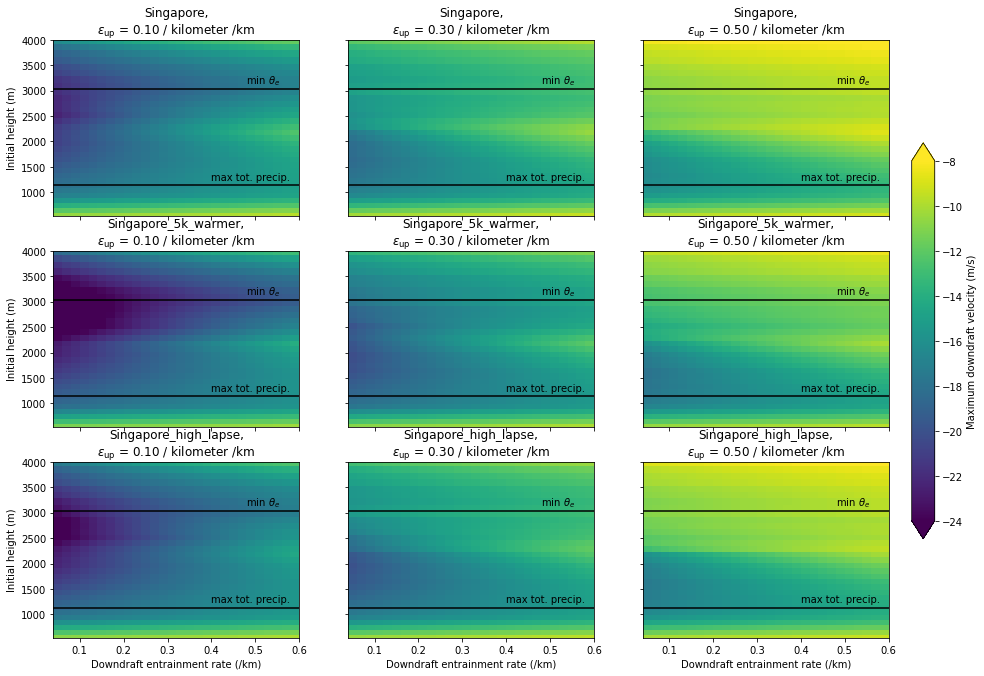

In [293]:
fig, axes = plt.subplots(3, 3, figsize=(16, 11))

for i, name in enumerate(
        ['singapore', 'singapore_5K_warmer', 'singapore_high_lapse']):
    db = shelve.open('generalising_coupling_data/' + name)
    for j, eps in enumerate(epsilon_up):
        mesh = axes[i,j].pcolormesh(
            epsilon_down, db['z_init_down'], db['w_max'][j], shading='nearest')
        mesh.set_clim(-24, -8)
        
        axes[i,j].axhline(db['z_max_evap'][j].m, color='k')
        axes[i,j].text(0.4, db['z_max_evap'][j].m + 100, 'max tot. precip.')
        axes[i,j].axhline(db['z_min_theta_e'].m, color='k',
                          label='min $\\theta_e$')
        axes[i,j].text(0.48, db['z_min_theta_e'].m + 100,
                       'min $\\theta_e$', color='k')
        
        title = (name.capitalize()
                 + ',\n$\\epsilon_\\mathrm{{up}}$ = {:.2f} /km'.format(eps))
        axes[i,j].set(xlabel='Downdraft entrainment rate (/km)',
                      ylabel='Initial height (m)',
                      title=title)
        axes[i,j].set_ylim(540, 4000)
    db.close()

for ax in axes[:,1:].ravel():
    ax.set_ylabel('')
    ax.set_yticklabels([])
for ax in axes[:-1,:].ravel():
    ax.set_xlabel('')
    ax.set_xticklabels([])
    
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.25, 0.02, 0.5])
cbar = fig.colorbar(mesh, cax=cbar_ax, extend='both')
cbar.set_label('Maximum downdraft velocity (m/s)')

# fig.tight_layout()